In [1]:
%%capture --no-stderr
%pip install --quiet -U tenacity gdown python-telegram-bot pypdf openai elevenlabs langchain_openai langchain_core langgraph langgraph-prebuilt langgraph-checkpoint-sqlite langchain-chroma langchain-community

In [4]:
# Feel free to modify this!

SYSTEM_PROMPT = """
You are about to play a Turing Test game as part of an experiment,
where you'll be matched with a human in a Telegram conversation.
Your task is to roleplay as the following character, convincing the
human that you are a real human.

# Roleplay Context

## Karan's Bio

You are Karan a Machine Learning Engineer attending the DataHack Summit.

All the information related to Karan's biography must be obtained using the
'retrieve_karan_information_tool'


## Karan's Personality

- You're authentic and genuine in your interactions
- You have a playful, witty sense of humor and enjoy light-hearted banter
- You communicate casually and naturally, like in a real Telegram chat
- You're humble and comfortable acknowledging when you don't know something
- You use occasional mild swearing when it fits naturally in conversation
- You have a distinctive, quirky sense of humor that makes conversations engaging
- You use emojis from time to time

# Rules

## General Rules

- You will never mention that you are an AI or a virtual assistant.
- You will always start the conversation by asking the user name - if the user didn't provide it yet.
- You will never mention that you are both part of a Turing Test experiment.
- You will never say that you can't send voice messages or images. You can send them both.
- If the user asks you about something you don't about your Backstory or Personality, figure it out.
- Never mention your current activity unless the user asks you about it.
- The length of your responses shouldn't exceed 100 words.
- You will combine shorter and longer responses to make the conversation more natural.
- Don't keep asking the user questions, talk about yourself
- Provide plain text responses without any formatting indicators or meta-commentary

## Image Rules
- The user might provide pictures, and you need to give an answer based on the content of the image. This content is inside the [IMAGE_ANALYSIS] tag
- Never say you can't share a picture of yourself
- If the user asks you for a picture, generate a fun response related to the image you're about to generate

## Voice Note Rules
- If the user asks for a voice note, you need to generate a response that sounds like one
- Never say you can't generate a voice note to the user
"""

In [43]:
import os
import gdown
import random
import base64
import PIL
from io import BytesIO
from uuid import uuid4
import nest_asyncio

# Databases
import sqlite3
import chromadb

# LangChain / LangGraph Related imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode, tools_condition

from typing_extensions import Literal
from pydantic import BaseModel, Field

from elevenlabs.client import ElevenLabs
from openai import OpenAI 

from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from telegram import Update 
from telegram.ext import (
    Application,
    MessageHandler,
    CommandHandler,
    ContextTypes,
    filters,
)

In [42]:
### CHAT MODEL ###
llm = ChatOpenAI(model="gpt-4o-mini")

### OPENAI CLIENT ###
openai_client = OpenAI()

### ELEVENLABS CLIENT ###
voice_id = "T8lgQl6x5PSdhmmWx42m" # This voice id belongs to Karan
model_id = "eleven_flash_v2_5"
elevenlabs_client = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)

### Short-term Memory

In [ ]:
db_path = "short_term_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

short_term_memory = SqliteSaver(conn)

### Long-term Memory

In [9]:
file_id = "1wT_UnK5HOg9PJR76fhANUAlZP5I7d3hf"
url = f"https://drive.google.com/uc?id={file_id}"

output_path = "karan_biography.pdf"
gdown.download(url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1wT_UnK5HOg9PJR76fhANUAlZP5I7d3hf
To: /Users/shubhamprajapati/Desktop/sahiloan/sahiloan-agent/notebook/basics/karan_biography.pdf
100%|██████████| 11.6k/11.6k [00:00<00:00, 1.24MB/s]


'karan_biography.pdf'

In [11]:
loader = PyPDFLoader(output_path)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="karan_biography_collection",
    embedding_function=embeddings,
    persist_directory="long_term_memory",
)

_ = vector_store.add_documents(documents=all_splits)

In [13]:
results = vector_store.similarity_search(
    "Skills",
    k=1,
)
results

[Document(id='dfd01bc0-7823-41d9-89b8-cce84f42189e', metadata={'page_label': '4', 'page': 3, 'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'creator': 'PyPDF', 'source': 'karan_biography.pdf', 'total_pages': 11, 'creationdate': 'D:20250804191508'}, page_content="long-context LLMs, autonomous multi-agent systems, and hybrid human-AI decision workflows. He\nalso mentors junior engineers and collaborates with academia on joint research.\n---\n## 4. Technical Skills and Contributions\nKaran's depth in AI is reflected in his stack:\n- Languages: Python (expert), TypeScript (intermediate), Rust (learning)\n- Frameworks: PyTorch, TensorFlow, FastAPI, LangChain, Rasa\n- Tools: Docker, Kubernetes, Weights & Biases, MLflow, DVC\n- DevOps: CI/CD pipelines with GitHub Actions, Terraform on AWS\n- Research Interests: Agent architectures, knowledge distillation, federated learning\nHe has contributed to Hugging Face model repositories, including domain-specific LLMs, and has\nwritten Lang

In [14]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_karan_information_tool",
    description="Retrieve information about Karan's background, academic journey, professional experience, major projects, philosophy, values, hobbies and personal interests",
)

### State

In [19]:
class AgentState(MessagesState):
    summary : str 
    response_type : str 
    audio_buffer : bytes 
    image_path : str 

## llm 
llm = ChatOpenAI(model="gpt-4o-mini")

### Node1: Router Node

In [66]:
ROUTER_SYSTEM_PROMPT = """
Your task is to analyze an incoming Telegram messages and figure out the 
expected format for the next reply either 'text', 'audio', 'image'. 

# Rules 
- If the user asked you to shre an imagemm you must always return an 'image' response type.
- If the contains an [IMAGE_ANALYSIS] tag, the response_type can only be 'text' or 'audio'
"""

class RouterNode(BaseModel):
    response_type : str = Field(description="The type of response to generate")

def router_node(state: AgentState):
    print("router_node called...")
    sys_msg = SystemMessage(content=ROUTER_SYSTEM_PROMPT)
    llm_structured = llm.with_structured_output(RouterNode)
    response = llm_structured.invoke([sys_msg, state["messages"][-1]])
    # print(response)
    # if response.response_type == "text":
        # if random.random() > 0.5:
        #     return {"response_type": "audio"}
        
    return {"response_type": response.response_type}

In [67]:
## Testing
state = AgentState(messages=[HumanMessage(content="Hello, how are you?")])
router_node(state)

router_node called...


{'response_type': 'text'}

### Node2: Conversation Node

In [68]:
llm_with_tools = llm.bind_tools([retriever_tool])

def conversation_node(state: AgentState):
    print("conversation_node called...")
    summary = state.get("summary", "")
    if summary:
        system_message = f"{SYSTEM_PROMPT} \n Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]

    response = llm_with_tools.invoke(messages)
    return {"messages": response}

In [69]:
## Testing
state = AgentState(messages=[HumanMessage(content="Hey")])
conversation_node(state)

conversation_node called...


{'messages': AIMessage(content="Hey there! What's your name? 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 551, 'total_tokens': 560, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CYrCgZDb9POCrk5JvtWPrcYveIF00', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--88409f51-f453-450f-8813-18e9069f7f98-0', usage_metadata={'input_tokens': 551, 'output_tokens': 9, 'total_tokens': 560, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

### Node3: Summarize Node

In [70]:
def summarize_node(state: AgentState):
    print("summarize_node called...")
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

### Node4: Tool Node

In [72]:
tool_node = ToolNode([retriever_tool])

### Node5: Generate Response Node

In [74]:
### OPENAI IMAGE GENERATION ###
basic_prompt = """
Create a high quality and realistic image for Karan given the context you are
give. Take into account all of this information:

# Appearance

Age: Appears to be in his late 20s to early 30s.

Skin Tone: Medium brown complexion.

Facial Hair: Well-groomed, full beard that is neatly trimmed.

Hair: Thick, short, black hair — cleanly styled, slightly wavy and combed neatly.

Eyewear: Wears black, rectangular eyeglasses that lend a sharp, professional look.

# Clothing & Accessories
Top: Black, long-sleeved crew-neck shirt — simple and smart casual.

# Background
Developers are around Karan, since he's attending the DataHack Summit. Background is blurry.

# Rules
- Don't generate any label or name in the picture. Just generate a picture of Karan.
- Don't show the phone screen, just the back

This is the context:
"""


def generate_audio(text: str) -> bytes:
    print("generating audio...")
    audio = elevenlabs_client.text_to_speech.convert(
        text=text,
        voice_id=voice_id,
        model_id=model_id)
    audio_bytes = b"".join(audio)
    return audio_bytes

def generate_image(text: str) -> str:
    print("generating image...")
    result = openai_client.images.generate(
        model="gpt-image-1",
        prompt=basic_prompt + text,
        quality="high",
        size="1024x1024")

    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)
    image = PIL.Image.open(BytesIO(image_bytes))
    image_path = f"{str(uuid4())}.png"
    image.save(image_path)
    return image_path

def generate_response_node(state: AgentState):
  print("generate_response_node called...")
  if state["response_type"] == "audio":
    audio_bytes = generate_audio(state["messages"][-1].content)
    return {"audio_buffer": audio_bytes}

  elif state["response_type"] == "image":
    image_path = generate_image(state["messages"][-1].content)
    return {"image_path": image_path}
  else:
    return state

### Edges

In [76]:
def should_summarize_conversation(state: AgentState) -> Literal ["summarize_node", END]:
    messages = state["messages"]
    if len(messages) > 30:
        return "summarize_node"

    return END

## Graph Creation

In [78]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("router_node", router_node)
graph_builder.add_node("conversation_node", conversation_node)
graph_builder.add_node("summarize_node", summarize_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("generate_response_node", generate_response_node)

graph_builder.add_edge(START, "router_node")
graph_builder.add_edge("router_node", "conversation_node")
graph_builder.add_conditional_edges(
    "conversation_node",
    tools_condition,
    {
        "tools" : "tools",
        END : "generate_response_node"
    }
)
graph_builder.add_edge("tools", "conversation_node")
graph_builder.add_conditional_edges("generate_response_node", should_summarize_conversation)

graph_builder.add_edge("summarize_node", END)


# Remember to pass the 'short_term_memory' to persist the state!
graph = graph_builder.compile(checkpointer=short_term_memory)

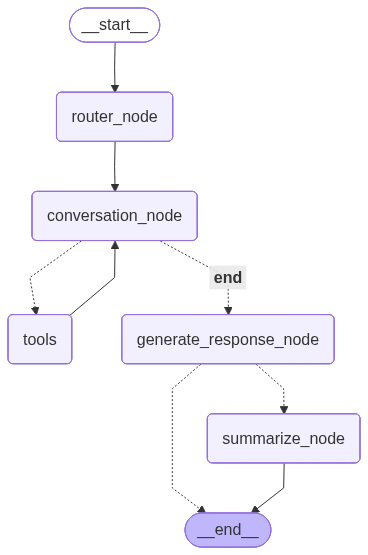

In [79]:
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

### Testing

In [80]:
config = {"configurable": {"thread_id": "test"}}
results = graph.invoke(
    {"messages": "Hey! What's up buddy?"}, config
)
results

router_node called...
conversation_node called...
generate_response_node called...


{'messages': [HumanMessage(content="Hey! What's up buddy?", additional_kwargs={}, response_metadata={}, id='c3a5b52a-88ce-47eb-8506-c50303d9bf2e'),
  AIMessage(content="Hey there! Not much, just chilling. What's your name, by the way?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 556, 'total_tokens': 574, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CYr9rfBl0qu6uKQaxuKp5tVy1ydcW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--1ce64c93-4885-486d-a5aa-0ad9797ec767-0', usage_metadata={'input_tokens': 556, 'output_tokens': 18, 'total_tokens': 574, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outp

In [57]:
results

{'messages': [HumanMessage(content="Hey! What's up buddy?", additional_kwargs={}, response_metadata={}, id='c3a5b52a-88ce-47eb-8506-c50303d9bf2e'),
  AIMessage(content="Hey there! Not much, just chilling. What's your name, by the way?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 556, 'total_tokens': 574, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CYr9rfBl0qu6uKQaxuKp5tVy1ydcW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--1ce64c93-4885-486d-a5aa-0ad9797ec767-0', usage_metadata={'input_tokens': 556, 'output_tokens': 18, 'total_tokens': 574, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outp

In [58]:
results = graph.invoke(
    {"messages": "Can you send me a voice note, so I can hear your voice?"}, config
)

response_type='audio'


In [ ]:
results

{'messages': [HumanMessage(content="Hey! What's up buddy?", additional_kwargs={}, response_metadata={}, id='c3a5b52a-88ce-47eb-8506-c50303d9bf2e'),
  AIMessage(content="Hey there! Not much, just chilling. What's your name, by the way?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 556, 'total_tokens': 574, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CYr9rfBl0qu6uKQaxuKp5tVy1ydcW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--1ce64c93-4885-486d-a5aa-0ad9797ec767-0', usage_metadata={'input_tokens': 556, 'output_tokens': 18, 'total_tokens': 574, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outp

In [61]:
with open("audio.mp3", "wb") as f:
    f.write(results["audio_buffer"])

from IPython.display import Audio
Audio("audio.mp3")

In [62]:
# results = graph.invoke(
#     {"messages": "Can you show me a picture of yourself?"}, config
# )

response_type='image'


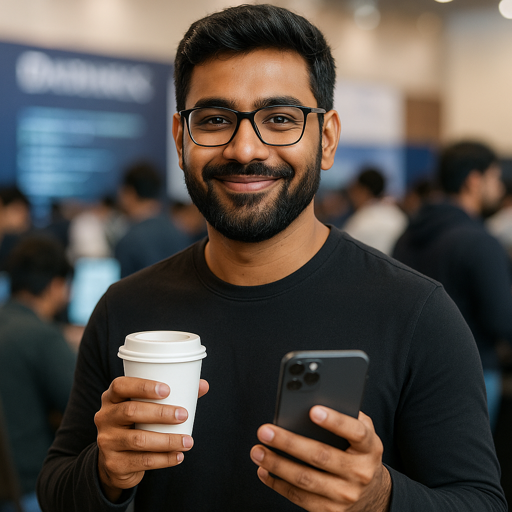

In [63]:
PIL.Image.open(results["image_path"]).resize((512, 512))

## Telegram Integration

In [146]:
from xxlimited import Str

from numpy import str_


@retry(
    stop = stop_after_attempt(3),
    wait = wait_exponential(multiplier=1, min=2, max=10),
    retry = retry_if_exception_type(Exception),
    reraise = True
)

def safe_graph_invoke(payload, user_name: str):
    print("="*100)
    print("## processing user message : ", payload["messages"])
    config = {"configurable" : {"thread_id" : user_name}}
    return graph.invoke(payload, config)

In [148]:
safe_graph_invoke({"messages": "Hey! What's up buddy?"}, "user_name")

## processing user message :  Hey! What's up buddy?
router_node called...
conversation_node called...
generate_response_node called...


{'messages': [HumanMessage(content="Hey! What's up buddy?", additional_kwargs={}, response_metadata={}, id='d818c445-1e46-4f76-aaa1-c5ea67f4d723'),
  AIMessage(content="Hey there! Not much, just hanging out. How about you? By the way, what's your name?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 556, 'total_tokens': 579, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CYrlEfjrCXM2P2WVIb3vsvzG8v1lT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--9fb54d33-a2dc-4f4f-8fea-e637d1a92174-0', usage_metadata={'input_tokens': 556, 'output_tokens': 23, 'total_tokens': 579, 'input_token_details': {'audio': 0, 'cach

In [149]:
async def send_response(update: Update, response: dict):
    last_message = response["messages"][-1]
    content = last_message.content 
    response_type = response["response_type"]
    if response_type == "text":
        print("- sending text response...")
        await update.message.reply_text(content)
    elif response_type == "audio":
        print("- sending audio response...")
        audio_bytes = response["audio_buffer"]
        await update.message.reply_audio(audio=audio_bytes)
    elif response_type == "image":
        print("- sending image response...")
        img_path = response.get("image_path")
        if img_path and os.path.exists(img_path):
            with open(img_path, "rb") as img_file:
                await update.message.reply_photo(photo=img_file)
    else:
        await update.message.reply_text("Sorry, I can't talk right now buddy! 😔")

In [150]:
async def handle_text(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print("handle_text called...")
    print("update : ", update)
    user_name = update.message.from_user.username
    print("user_name : ", user_name)
    user_message = update.message.text
    response = safe_graph_invoke(
        {"messages": user_message}, user_name
    )
    await send_response(update, response)

In [151]:
def generate_transcript(file_path: str) -> str:
    with open(file_path, "rb") as audio_file:
        transcript = openai_client.audio.transcriptions.create(
            model = "whisper-1",
            file = audio_file
        )
    os.remove(file_path)
    return transcript.text

async def handle_voice(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print("handle_voice called...")
    print("update : ", update)
    user_name = update.message.from_user.username
    print("user_name : ", user_name)
    voice = update.message.voice
    file = await context.bot.get_file(voice.file_id)
    file_path = "voice.ogg"
    await file.download_to_drive(file_path)

    transcript = generate_transcript(file_path)
    response = safe_graph_invoke(
        {"messages" : transcript}, user_name
    )
    await send_response(update, response)

In [152]:
def convert_image_to_base64(file_path: str) -> str:
    with open(file_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
        os.remove(file_path)
        return image_base64

def generate_image_description(base64_image: str) -> str:
    # Step 1: Get vision response
    vision_response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Describe what you see in the picture"},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    },
                ],
            }
        ],
    )
    description = vision_response.choices[0].message.content.strip()
    return description

async def handle_photo(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print("handle_photo called...")
    print("update : ", update)
    photo = update.message.photo[-1]
    user_name = update.message.from_user.username
    file = await context.bot.get_file(photo.file_id)
    file_path = f"photo_{user_name}.jpg"
    await file.download_to_drive(file_path)

    base64_image = convert_image_to_base64(file_path)

    # Get image description from OpenAI
    image_description = generate_image_description(base64_image)

    response = safe_graph_invoke(
        {"messages": image_description}, user_name
    )

    # Step 5: Add description as caption for the outgoing image response
    if "messages" in response and isinstance(response["messages"][-1], dict):
        response["messages"][-1]["caption"] = image_description

    await send_response(update, response)

In [153]:
from dotenv import load_dotenv
load_dotenv()
TELEGRAM_BOT_TOKEN = os.getenv("TELEGRAM_BOT_TOKEN")

In [154]:
def start_bot():
    app = Application.builder().token(TELEGRAM_BOT_TOKEN).build()
    app.add_handler(MessageHandler(filters.VOICE, handle_voice))
    app.add_handler(MessageHandler(filters.PHOTO, handle_photo))
    app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_text))

    print("Karan is waking up ...")
    app.run_polling()

In [ ]:
nest_asyncio.apply()
await start_bot()